# Who should you take in the NFL draft? - QB Edition

## Quarterback -- in preparation 


In this notebook I attempt at predicting who will be a probowl quarterback based on Combine metrics. Let's see if it works..

In [303]:
import pandas as pd
import numpy as np
import itertools

from sklearn.cross_validation import cross_val_score
from sklearn import linear_model, ensemble, decomposition, preprocessing, metrics
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

from imblearn.over_sampling import SMOTE

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
plt.style.use('ggplot')

Only take quarterbacks from our dataset:

In [429]:
df = pd.read_csv('/Users/richard/data/NFL.csv', index_col='idx')
df = df[df['Pos'] == 'QB']

How many made it to the probowl?

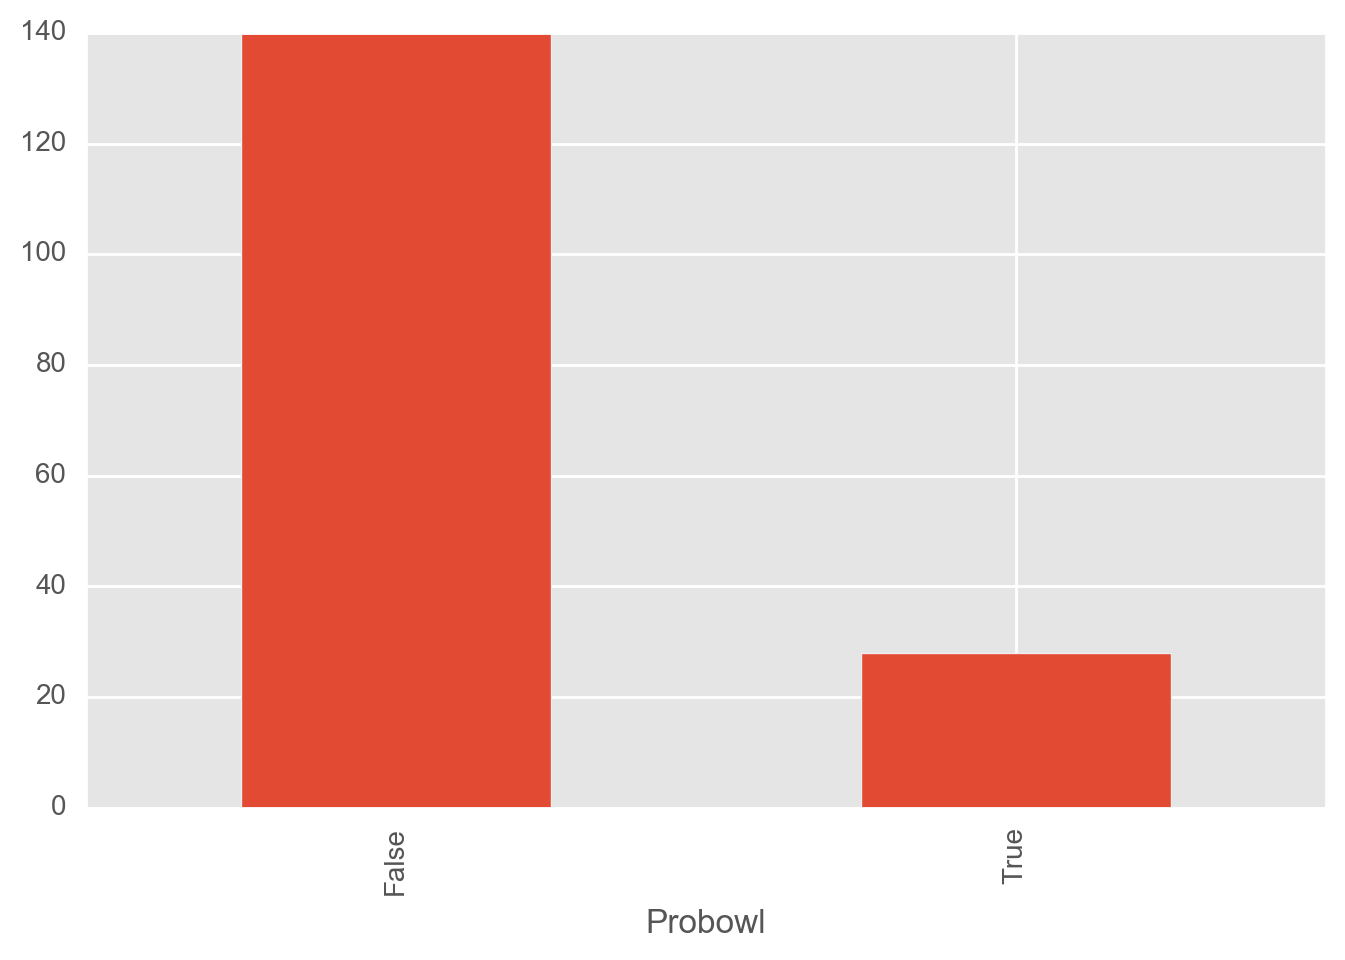

In [432]:
df.groupby('Probowl').size().sort_values(ascending=False).plot(kind='bar');

21 players out of 140 made it to the probowl. Ok, that's going to be a tough sell, no matter what kind of machine learning magician you are. Still.. let's continue.

First thing's first. Machine learning algorithms don't like nans. Let's see which columns in our dataset have the most missing values:

In [434]:
df.isnull().sum().sort_values(ascending=False)

BenchReps        160
Shuttle           44
3Cone             44
Vertical          39
Broad Jump        36
40YD               2
Probowl            0
Height_inches      0
Wt                 0
School             0
Pos                0
Player             0
Year               0
dtype: int64

Alright, so down here is where we do the feature selection, the training and the evaluation with a confusion matrix:

108 58
Confusion matrix, without normalization
[[43  6]
 [ 5  4]]


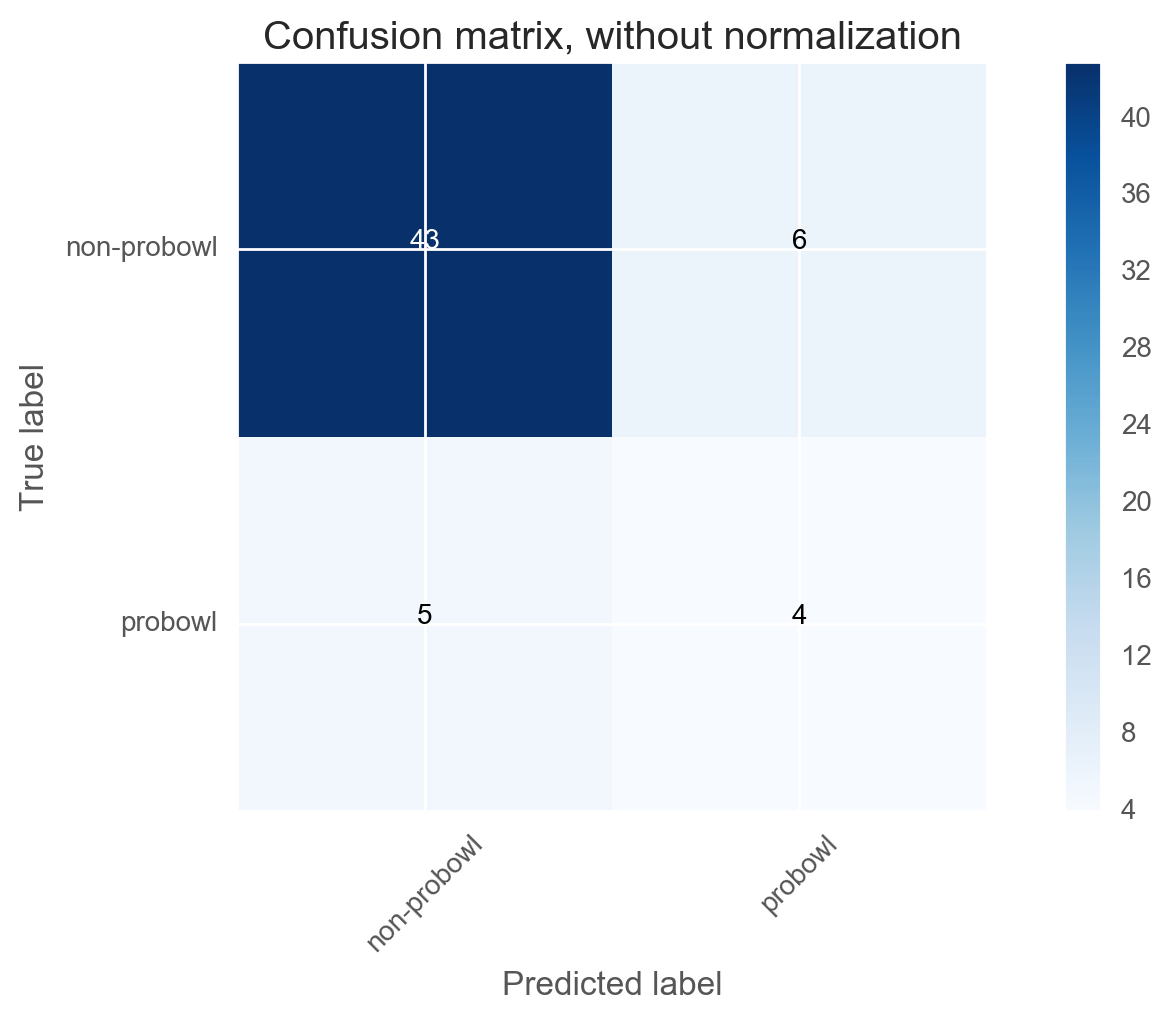

In [436]:
cutoff_year = 2010
important_cols = ['Wt','40YD', 'Height_inches', 'Probowl', 'Player']
df = df_qb

df_train   = df[df['Year'] < cutoff_year]
df_test    = df[df['Year'] >= cutoff_year]

df_train = df_train[important_cols].dropna()
df_test  = df_test[important_cols].dropna()

X_train = df_train.drop(['Probowl', 'Player'],1)
X_test  = df_test.drop(['Probowl', 'Player'],1)

y_train = df_train.Probowl
y_test = df_test.Probowl

print(len(y_train), len(y_test))

rf = ensemble.ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
rf.fit(X_train, y_train)

binarizer = preprocessing.Binarizer(threshold=0.39)
x = rf.predict_proba(X_test)[:,1]

arr = np.zeros((len(y_test),5))

arr[:,0] = np.round(rf.predict_proba(X_test)[:,0],2)
arr[:,1] = np.round(rf.predict_proba(X_test)[:,1],2)
arr[:,2] = np.array(rf.predict(X_test))
arr[:,3] = binarizer.transform(x)
arr[:,4] = np.array(y_test)
results = pd.DataFrame(arr, columns=['non probowl prob', 'probowl prob', 'prediction', 'adjusted prediction', 'actual'])

cnf_matrix = metrics.confusion_matrix(results['actual'], results['adjusted prediction'])
plot_confusion_matrix(cnf_matrix, classes=['non-probowl', 'probowl'], title='Confusion matrix, without normalization')

Well, I don't hate the algorithm. Out of 10 predicted probowl quarterbacks, it gets 4 right. Miami hasn't gotten one right since Dan Marino, at least my algorithm would have gotten 4.

Also, it's not bad at telling you who probably *won't* make it to the probowl

## Predictions for 2016 probowlers

to be continued..

In [438]:
# Utility function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')